In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits

In [ ]:
os.chdir('/home/walml/repos/agnfinder')

In [8]:
# wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
#         8917.58185532, 16397.13029184, 12513.8266968 , 
#        10205.12640526])

quantile_spreads = [10, 25, 50, 75, 90, 95]

In [9]:
galaxy_locs = all_galaxy_locs

In [12]:
# open one galaxy for params
with h5py.File(galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

marginal_bins = 50
dummy_array = np.zeros(42)  # anything
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=marginal_bins)
                
galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
#         print(f['is_accepted'][...].mean())
#             if f['is_accepted'][...].mean() < 0.6:
#                 print(f['is_accepted'])
#             else:
                galaxy = {
#                     'free_param_names': f['free_param_names'],
                    'samples': np.squeeze(f['samples'][::100]),
                    'name': galaxy_loc.split('_')[-3],
                    'chain': galaxy_loc.split('_')[-1].rstrip('.h5'),
                    'true_observations': np.squeeze(f['true_observations'][...]),
                    'true_params': np.squeeze(f['true_params'][...]),
#                     'redshift': f['fixed_params'][...],
                    'uncertainty': f['uncertainty'][...],
                }
                
                samples = np.squeeze(f['samples'][...])
                for spread in quantile_spreads:
                    galaxy[f'percentile_spreads_{spread}'] = parameter_recovery.percentile_spreads(samples, spread)
                
                galaxy['marginals'] = f['marginals'][...]
                galaxy['marginal_bins'] = param_bins
                
                
                galaxies.append(galaxy)
                
    except OSError:
        pass
    
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [13]:
galaxy['percentile_spreads_10']

array([0.00256348, 0.04443359, 0.00585938, 0.01104736, 0.06262207,
       0.13183594, 0.07019043, 0.10717773])

In [14]:
galaxy['marginal_bins'].shape

(51,)

In [15]:
galaxy['marginals'].shape

(8, 50)

## Which are failures?

In [12]:
p_by_param = percentile_limits.get_surprise(galaxy)
p_by_param

array([2.375   , 1.429375, 0.940625, 0.97375 , 5.484375, 6.230625,
       0.930625, 1.065625])

In [14]:
surprise = np.array([percentile_limits.get_surprise(galaxy) for galaxy in galaxies])

In [15]:
surprise.shape

(1005, 8)

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning:invalid value encountered in greater_equal
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning:invalid value encountered in less_equal


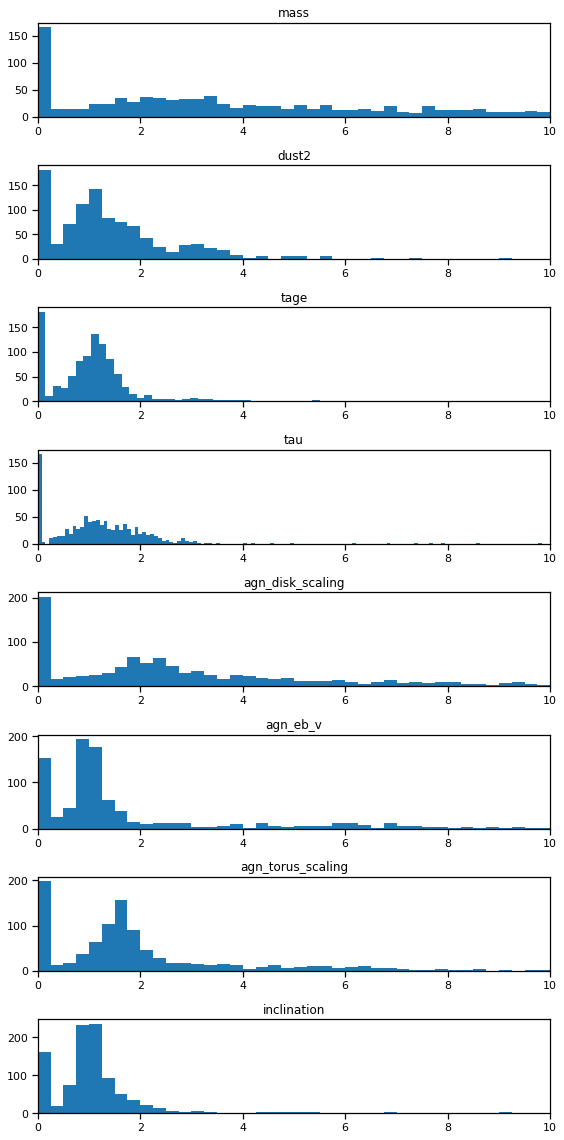

In [16]:
fig, axes = plt.subplots(nrows=8, figsize=(8, 16))
for param_n in range(8):
    ax = axes[param_n]
    ax.hist(surprise[:, param_n], bins=200)
    ax.set_title(params[param_n])
    ax.set_xlim([0., 10.])
fig.tight_layout()

Alright, looks like a population of clear failures. Let's cut it out!

In [17]:
np.sum(surprise < 0.0000001)

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:invalid value encountered in less


1258

In [18]:
np.sum(surprise < 0.0000001)/surprise.size

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:invalid value encountered in less


0.15646766169154228

In [19]:
np.sum(np.any(surprise < 0.0000001, axis=1)), np.sum(np.all(surprise < 0.0000001, axis=1))

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning:invalid value encountered in less


(206, 85)

15% or so have stupendously unlikely posterior values.

Let's double check this is working right:

In [74]:
# galaxy_is_bad = np.all(surprise < 0.0000001, axis=1)
galaxy_is_bad = np.any(surprise < 0.0000001, axis=1)
bad_galaxy_indices = np.arange(len(galaxies))[galaxy_is_bad]
good_galaxy_indices = np.arange(len(galaxies))[~galaxy_is_bad]
bad_galaxy_indices

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning:invalid value encountered in less


array([   1,   21,   22,   23,   32,   37,   39,   41,   42,   46,   52,
         64,   70,   73,   79,   89,   93,   99,  119,  123,  125,  132,
        134,  135,  136,  137,  141,  148,  154,  159,  161,  165,  168,
        174,  175,  189,  195,  203,  205,  218,  225,  226,  233,  236,
        237,  252,  260,  262,  266,  268,  271,  281,  298,  303,  314,
        318,  320,  321,  322,  331,  335,  346,  347,  360,  367,  368,
        370,  374,  380,  382,  394,  396,  397,  402,  405,  410,  411,
        413,  418,  422,  428,  432,  437,  440,  443,  447,  452,  453,
        463,  464,  479,  483,  485,  492,  511,  512,  514,  521,  527,
        528,  531,  532,  537,  539,  540,  541,  546,  547,  558,  559,
        562,  574,  576,  578,  582,  584,  588,  590,  596,  602,  611,
        616,  618,  624,  629,  635,  636,  645,  654,  655,  660,  665,
        667,  668,  672,  684,  700,  701,  703,  714,  723,  727,  737,
        743,  745,  751,  764,  773,  774,  776,  7

In [75]:
bad_galaxy = galaxies[bad_galaxy_indices[0]]
list(zip(bad_galaxy['true_params'], np.median(bad_galaxy['samples'], axis=0)))

[(0.7430308, 0.9007686),
 (0.5811921, 0.18404469),
 (0.6477517, 0.68238246),
 (0.8259002, 0.24476099),
 (0.12322705, 0.26976585),
 (0.42209268, 0.20206669),
 (0.9818219, 0.91029954),
 (0.78383416, 0.78335965)]

In [76]:
good_galaxy = galaxies[good_galaxy_indices[0]]
list(zip(good_galaxy['true_params'], np.median(good_galaxy['samples'], axis=0)))

[(0.27136666, 0.25355256),
 (0.2877757, 0.48166662),
 (0.3593122, 0.075577945),
 (0.76999146, 0.31058797),
 (0.3843126, 0.43986726),
 (0.2874543, 0.45864096),
 (0.75265276, 0.7627716),
 (0.31316066, 0.30276906)]

Alright, that's working. Now what's the difference?

In [77]:
bands = ['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
        'VISTA_J', 'VISTA_Y']
errors = ['u_sloan_err', 'g_sloan_err', 'r_sloan_err', 'i_sloan_err',
        'z_sloan_err', 'VISTA_H_err', 'VISTA_J_err',
        'VISTA_Y_err']

In [78]:
def galaxy_to_row(galaxy):
    row = {}
    for param_n in range(len(params)):
        param = params[param_n]
        row[param] = np.median(galaxy['samples'], axis=0)[param_n]
        for spread in quantile_spreads:
            row[f'{param}_pc_{spread}'] = galaxy[f'percentile_spreads_{spread}'][param_n]
    for band_n in range(len(bands)):
        row[bands[band_n]] = galaxy['true_observations'][band_n]
        row[errors[band_n]] = galaxy['uncertainty'][band_n]
    return row

In [79]:
data = [galaxy_to_row(galaxy) for galaxy in galaxies]
df = pd.DataFrame(data)
df['success'] = ~galaxy_is_bad
df.head()

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning:overflow encountered in reduce


,mass,mass_pc_10,mass_pc_25,mass_pc_50,mass_pc_75,mass_pc_90,mass_pc_95,dust2,dust2_pc_10,dust2_pc_25,...,i_sloan_err,z_sloan,z_sloan_err,VISTA_H,VISTA_H_err,VISTA_J,VISTA_J_err,VISTA_Y,VISTA_Y_err,success
0,0.253553,0.012370,0.027004,0.049343,0.078549,0.124621,0.164713,0.481667,0.008052,0.057413,...,4.767725e-09,3.103303e-07,9.309908e-09,6.680905e-07,2.004271e-08,5.326534e-07,1.597960e-08,5.121136e-07,1.536341e-08,True
1,0.900769,0.025253,0.062905,0.127235,0.194216,0.243752,0.265618,0.184045,0.039948,0.108411,...,6.147568e-07,4.605276e-05,1.381583e-06,8.637537e-05,2.591261e-06,1.211136e-04,3.633409e-06,8.314736e-05,2.494421e-06,False
2,0.708336,0.012457,0.032074,0.066455,0.107159,0.136686,0.150518,0.470734,0.038297,0.100114,...,4.364775e-10,1.680818e-08,1.543467e-09,3.884844e-08,2.838890e-09,2.964826e-08,2.505752e-09,2.075492e-08,1.447900e-09,True
3,0.548363,0.012900,0.032945,0.068094,0.106830,0.140743,0.166630,0.237937,0.044325,0.111404,...,9.104403e-11,9.440783e-10,1.416118e-10,2.726054e-09,4.089081e-10,1.947204e-09,2.920807e-10,1.200215e-09,1.800322e-10,True
4,0.128576,0.026413,0.067614,0.140333,0.226895,0.302580,0.332334,0.423922,0.105854,0.245417,...,2.093991e-10,4.000249e-09,6.000374e-10,5.953112e-09,8.929668e-10,1.002373e-08,1.503560e-09,6.974997e-09,1.046250e-09,True


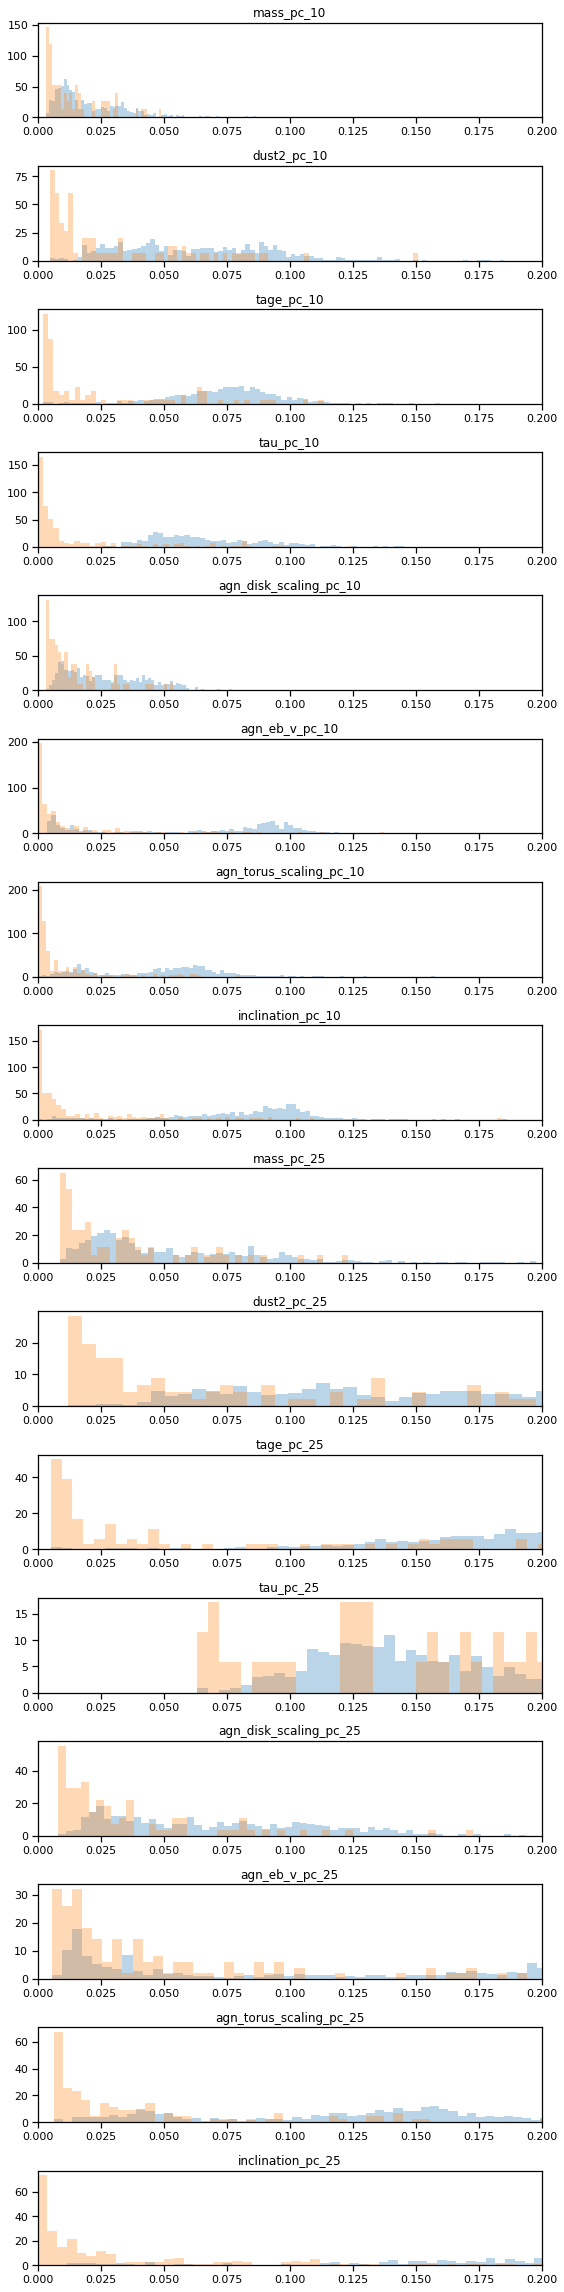

In [80]:
pc_cols = [x for x in df.columns.values if 'pc_10' in x] + [x for x in df.columns.values if 'pc_25' in x]

clipped_df = df.copy()
for col in pc_cols:
    clipped_df = df.query(f'{col} < 1.')
    
fig, axes = plt.subplots(nrows=len(pc_cols), figsize=(8, 2*len(pc_cols)))
for param_n in range(len(pc_cols)):
    ax = axes[param_n]
    _, bins, _ = ax.hist(clipped_df.query('success == True')[pc_cols[param_n]], density=True, alpha=0.3, bins=100)
    ax.hist(clipped_df.query('success == False')[pc_cols[param_n]], density=True, alpha=0.3, bins=bins)
    ax.set_title(pc_cols[param_n])
    ax.set_xlim([0., .2])
fig.tight_layout()


In [81]:
np.sum(clipped_df['tau_pc_10']< 0.02), np.sum(clipped_df['inclination_pc_10']< 0.01)

(161, 153)

In [82]:
predictions = (clipped_df['tau_pc_10']< 0.02) & (clipped_df['inclination_pc_10']< 0.01)

# f[~predictions]['success'].mean()

In [83]:
from sklearn.metrics import recall_score, precision_score

In [84]:
recall_score(clipped_df['success'], ~predictions), precision_score(clipped_df['success'], ~predictions)

(0.9987405541561712, 0.9062857142857143)

In [85]:
galaxy['percentile_spreads_10']

array([0.04064107, 0.0693201 , 0.09114488, 0.0904284 , 0.01981871,
       0.01446945, 0.09694459, 0.09270081])

In [86]:

# predictions.sum()
# predictions.sum(), clipped_df[predictions]['success'].mean(), clipped_d

In [87]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# clf = RandomForestClassifier(max_depth=2, n_estimators=1)
clf = DecisionTreeClassifier(max_depth=2)

X = clipped_df[pc_cols]
y = clipped_df['success'].values.reshape(-1)

results = cross_validate(clf, X, y, cv=3, scoring=['recall', 'precision'])
# # print(scores.mean()
results['test_recall'].mean(), results['test_precision'].mean()
# plot_tree(clf, filled=True)

(0.9911949685534592, 0.9645291855739617)

In [89]:
params

array(['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v',
       'agn_torus_scaling', 'inclination'], dtype=object)

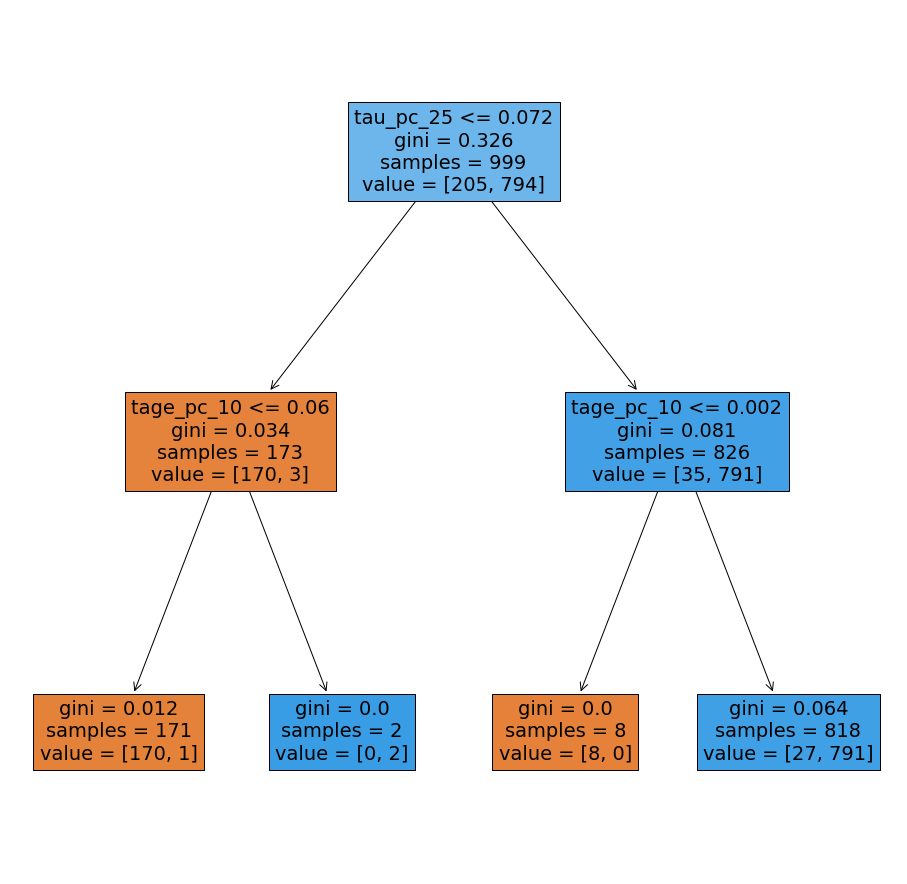

In [88]:
clf.fit(X, y)
fig, ax = plt.subplots(figsize=(16,16))
_ = plot_tree(clf, filled=True, ax=ax, feature_names=pc_cols)

agn disk scaling and inclination are the key cuts

In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

estimator = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
estimator.fit(X_train, y_train)


In [36]:
clf.tree_

AttributeError: 'DecisionTreeClassifier' object has no attribute 'tree_'

In [ ]:
clf.fit(X, y)
dict(zip(params, clf.feature_importances_))

In [ ]:
scores

## Identify failures with percentile spreads

In [ ]:
pcs = np.abs(np.array([x['percentile_spreads'] for x in galaxies]))
valid_pcs = pcs[np.all(pcs < 1., axis=1)]

In [ ]:
len(pcs), len(valid_pcs)

In [ ]:
fig, axes = plt.subplots(nrows=8, figsize=(8, 16))
for param_n in range(8):
    ax = axes[param_n]
    ax.hist(valid_pcs[:, param_n], bins=80)
    ax.set_title(params[param_n])
    ax.set_xlim([0., 1.])
fig.tight_layout()

In [ ]:
valid_pcs.shape

In [ ]:
limits = np.percentile(valid_pcs, q=12, axis=0)
limits

In [ ]:
# np.mean(valid_pcs < limits, axis|=1) > 0.

In [ ]:
np.mean(np.sum(valid_pcs < limits, axis=1) > 1.)

In [ ]:
galaxy['percentile_spreads']

In [ ]:
for galaxy in galaxies:
    galaxy['good_spread'] = np.sum(galaxy['percentile_spreads'] < limits) < 2.

In [ ]:
np.mean([g['good_spread'] for g in galaxies])

In [ ]:
data = galaxies.copy()
# for g in data:
#     del g['samples']
df = pd.DataFrame(data=data)
df.head()

In [ ]:
df.query('chain == "0"')['good_spread'].mean(), df.query('chain == "1"')['good_spread'].mean()

In [ ]:
bad_first_chains = df.query('good_spread == False').query('chain == "0"')
bad_first_chains.head()
bad_chains = bad_first_chains['name'].values

In [ ]:
bad_first_chains_df = df[df['name'].isin(bad_chains)]
rerun = bad_first_chains_df.groupby('name').agg({'good_spread': np.any}).reset_index()
rerun['good_spread'].mean()

In [ ]:
min_spread = 0.03
allowed_pcs = np.all(min_spread < valid_pcs, axis=1)
selected_pcs = valid_pcs[allowed_pcs]
fig, axes = plt.subplots(nrows=8, figsize=(8, 16))
for param_n in range(8):
    ax = axes[param_n]
    ax.hist(selected_pcs[:, param_n], bins=40)
    ax.set_title(params[param_n])
    ax.axvline(min_spread)
    ax.set_xlim([0., 1.])
fig.tight_layout()

In [ ]:
median_spreads = np.array([g['median_spread'] for g in galaxies])
median_spreads_no_inf = median_spreads[~np.isinf(median_spreads)]
(median_spreads_no_inf > 1).sum()
median_spreads_valid = median_spreads[median_spreads < 1]

In [ ]:
counts, bins, _ = plt.hist(median_spreads_valid, bins=100)

In [ ]:
bins

In [ ]:
_ = plt.hist(median_spreads_valid[(median_spreads_valid < 0.988) & (median_spreads_valid > 0.15)], bins=100)

In [ ]:
from agnfinder.tf_sampling import parameter_recovery

In [ ]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [ ]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [ ]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [ ]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [ ]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [ ]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [ ]:
parameter_recovery.main(save_dir, min_acceptance=0.6, max_redshift=1.)

In [ ]:
np.max(median_spreads), np.argmax(median_spreads), median_spreads[79]

In [ ]:
inf_galaxy = galaxies[np.argmax(median_spreads)]
inf_galaxy['samples'].min(), inf_galaxy['samples'].max()
inf_galaxy['samples'][0]
# plt.hist(inf_galaxy['samples'][0:3].flatten())

In [ ]:
inf_galaxy

In [ ]:
# corner.corner(inf_galaxy['samples'])
plt.loglog(wavelengths, inf_galaxy['true_observations'], marker='+', linestyle='')

In [ ]:
# broken_galaxy = galaxies[~np.isinf(median_spreads)][np.argmax(median_spreads)]
# broken_galaxy['median_spread']

In [ ]:
_ = corner.corner(broken_galaxy['samples'])

In [ ]:
plt.hist(median_spreads, bins=40)

In [ ]:
def median_spread(samples):
    return np.median(np.max(samples, axis=0) - np.min(samples, axis=0))

def percentile_spreads(samples):
    return np.percentile(samples, 75, axis=0) - np.percentile(samples, 25, axis=0)

In [ ]:
median_spread(galaxy['samples'])

In [ ]:
galaxy_loc

In [ ]:
galaxy = galaxies[1]

In [ ]:
galaxy['uncertainty'] / galaxy['true_observations']

In [ ]:
plt.loglog(wavelengths, galaxy['true_observations'], marker='+', linestyle='')

In [ ]:
galaxy['name'], galaxy['chain']

In [ ]:

# save_dir = 'results/emulated_sampling/real'
# save_dir = '/media/walml/beta/agnfinder_results/euclid_med_real_unc_fixed_z'
# save_dir = 'results/emulated_sampling/30k_burnin'
save_dir = 'results/emulated_sampling/latest_30000_1_optimised'

all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert all_galaxy_locs


